### This script takes data in a json file, trains a scope model on this data and saves it. Gives option to calculate the lexical overlap.

In [ ]:
# Installations needed
!pip install transformers
!pip install knockknock
!pip install sentencepiece

In [ ]:
!pip install -U ipykernel

In [ ]:
# Imports needed
import torch, json, random
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import transformers
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from transformers import BertForTokenClassification, BertTokenizer, XLMRobertaTokenizer, XLMRobertaForTokenClassification
from transformers.file_utils import cached_path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Upload the datasets to Google Drive.
This allows access to your Google Drive from this notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Set global variables for model configuration.

In [ ]:
MAX_LEN = 250
bs = 8 # batch size
EPOCHS = 32
PATIENCE = 9
INITIAL_LEARNING_RATE = 1e-5

SCOPE_MODEL = 'xlm-roberta-base' #'bert-base-uncased' 'bert-base-multilingual-cased'
SCOPE_METHOD = 'augment' # Options: augment, replace
TASK = 'negation' # Options: negation, speculation
SUBTASK = 'scope_resolution' # Options: cue_detection, scope_resolution
# TRAIN_DATASETS = ['french_corpus'] # 'french_corpus', 'sherlock', 'bioscope_full_papers','bioscope_abstracts', 'sfu'
MULTI_BERT_VOCAB = []

NAME OF THE MODEL THAT WILL BE SAVED


In [ ]:
root = '/content/gdrive/My Drive/multilingual_BERT_negations/modelsXLM/SP2_1878'
model_name = root + 'ENG2_1878'

CHOOSE TRAINING DATA


In [ ]:
file = '/content/gdrive/My Drive/multilingual_BERT_negations/all_data_2Qlabels/spanishALL_2labels.json'

In [ ]:
file2 = '/content/gdrive/My Drive/multilingual_BERT_negations/all_data_2Qlabels/SHERLOCK_3labels.json'

In [ ]:
file3 = '/content/gdrive/My Drive/multilingual_BERT_negations/all_data_2Qlabels/SFU_2label.json'

In [ ]:
with open(file, 'r') as inf:
  zipped_train = json.load(inf)

# with open(file2, 'r') as inf:
#   zipped_train2 = json.load(inf)

# with open(file3, 'r') as inf:
#   zipped_train3 = json.load(inf)

# zipped_train = zipped_train + zipped_train2 + zipped_train3

len(zipped_train)

4327

In [ ]:
def sample(iterable, k):
    training = []
    rest = []
    for t, item in enumerate(iterable):
        if t < k:
            training.append(item)
        else:
            m = random.randint(0, t)
            if m < k:
                item, training[m] = training[m], item
            rest.append(item)

    return training

zipped_train = sample(zipped_train, 1878)

len(zipped_train)

1878

In [ ]:
for item in zipped_train[:2]:
  print(item)

[['No', 'comparto', 'tu', 'opinión', 'pero', 'la', 'respeto', '.'], [1, 3, 3, 3, 3, 3, 3, 3], [0, 1, 1, 1, 0, 0, 0, 0]]
[['Pese', 'a', 'que', 'son', 'habitaciones', 'a', 'la', 'calle', ',', 'no', 'se', 'escuchan', 'ruidos', 'y', 'en', 'mi', 'caso', 'que', 'he', 'ido', 'siempre', 'en', 'verano', ',', 'los', 'equipos', 'de', 'aire', 'funcionan', 'muy', 'bien', '.'], [3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [ ]:
method = SCOPE_METHOD
do_lower_case = False

# print(SCOPE_MODEL)

if 'multilingual' in SCOPE_MODEL:
  tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=do_lower_case, cache_dir='multilingual_bert_tokenizer')

elif 'roberta' in SCOPE_MODEL:
  tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

my_vocab = []

In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
def preprocess_data(zipped, tokenizer_obj):
    dl_sents = [item[0] for item in zipped]
    dl_cues = [item[1] for item in zipped]
    dl_scopes = [item[2] for item in zipped]

    # print(dl_sents[1])
    sentences = [" ".join([s for s in sent]) for sent in dl_sents]
    mytexts = []
    mylabels = []
    mycues = []
    mymasks = []
    if do_lower_case == True:
        sentences_clean = [sent.lower() for sent in sentences]
    else:
        sentences_clean = sentences

    for sent, tags, cues in zip(sentences_clean, dl_scopes, dl_cues):
        new_tags = []
        new_text = []
        new_cues = []
        new_masks = []
        for word, tag, cue in zip(sent.split(), tags, cues):
            sub_words = tokenizer_obj._tokenize(word)

            # update tags and labels for subwords
            for count, sub_word in enumerate(sub_words):
                my_vocab.append(sub_word)
                # the first subword is the true token
                mask = 1
                if count > 0:
                    # all the other subwords that start with # receive a mask 0
                    # these will be the true_token_masks
                    mask = 0

                # start collecting masks for true and not true tokens
                new_masks.append(mask)

                # tags(scope) and cue labels stay the same for all the subwords
                new_tags.append(tag)
                new_cues.append(cue)
                new_text.append(sub_word)
        # true and not true tokens
        mymasks.append(new_masks)
        mytexts.append(new_text)
        mylabels.append(new_tags)
        mycues.append(new_cues)

    # start lists of final inputs
    final_sentences = []
    final_labels = []
    final_masks = []
    if method == 'replace':
        for sent,cues in zip(mytexts, mycues):
            temp_sent = []
            for token,cue in zip(sent,cues):
                if cue==3:
                    temp_sent.append(token)
                else:
                    temp_sent.append(f'[unused{cue+1}]')
            final_sentences.append(temp_sent)
        final_labels = mylabels
        final_masks = mymasks
    elif method == 'augment':
        # mylabels are scope tags
        # input is already subword-tokenized by BERT
        for sent, cues, labels, masks in zip(mytexts, mycues, mylabels, mymasks):

            temp_sent = []
            temp_label = []
            temp_masks = []
            first_part = 0
            for token, cue, label, mask in zip(sent, cues, labels, masks):
                # (token, 1, 0, 1)
                # find cues
                if cue!=3:
                    if first_part == 0:
                        first_part = 1
                        # add special token
                        temp_sent.append(f'[unused{cue+1}]')
                        # true_token_labels
                        temp_masks.append(1)
                        # scope label is 0 because it is a special token
                        temp_label.append(0)
                        # reconstruct the sentence
                        temp_sent.append(token)
                        # the actual token receives ZERO as true_token_label
                        temp_masks.append(0)
                        # scope label remains the same for the entire group of subwords
                        temp_label.append(label)
                        continue
                    # the other parts of the subword:
                    # add special token
                    temp_sent.append(f'[unused{cue+1}]')
                    # true_token_label is FALSE
                    temp_masks.append(0)
                    # scope_label stays the same for all the subwords. It is 0 because it's a cue.
                    temp_label.append(0)
                else:
                    # if the token is not a cue
                    first_part = 0
                temp_masks.append(mask)
                temp_sent.append(token)
                temp_label.append(label)
            final_sentences.append(temp_sent)
            final_labels.append(temp_label)
            final_masks.append(temp_masks)
    else:
        raise ValueError("Supported methods for scope detection are:\nreplace\naugment")

    input_ids = pad_sequences([[tokenizer_obj._convert_token_to_id(word) for word in txt] for txt in final_sentences],
                              maxlen=MAX_LEN, dtype="long", truncating="post", padding="post").tolist()

    tags = pad_sequences(final_labels,
                        maxlen=MAX_LEN, value=0, padding="post",
                        dtype="long", truncating="post").tolist()

    final_masks = pad_sequences(final_masks,
                        maxlen=MAX_LEN, value=0, padding="post",
                        dtype="long", truncating="post").tolist()

    attention_masks = [[float(i>0) for i in ii] for ii in input_ids]


    return [input_ids, tags, final_masks, attention_masks]

val_size = 0.20
random_state_2 = np.random.randint(1,2019)

# shuffle training data twice
random.shuffle(zipped_train)
random.shuffle(zipped_train)

print(zipped_train[2:22])

train_input_ids, train_tags, train_final_masks, train_attention_masks = preprocess_data(zipped_train, tokenizer)

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(train_input_ids, train_tags, test_size=val_size, random_state = random_state_2)
tr_masks, val_masks, _, _ = train_test_split(train_attention_masks, train_input_ids, test_size=val_size, random_state = random_state_2)
tr_mymasks, val_mymasks, _, _ = train_test_split(train_final_masks, train_input_ids, test_size=val_size, random_state = random_state_2)

tr_inputs = torch.LongTensor(tr_inputs)
tr_tags = torch.LongTensor(tr_tags)
tr_masks = torch.LongTensor(tr_masks)
tr_mymasks = torch.LongTensor(tr_mymasks)

val_inputs = torch.LongTensor(val_inputs)
val_tags = torch.LongTensor(val_tags)
val_masks = torch.LongTensor(val_masks)
val_mymasks = torch.LongTensor(val_mymasks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags, tr_mymasks)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

val_data = TensorDataset(val_inputs, val_masks, val_tags, val_mymasks)
val_sampler = RandomSampler(val_data)
val_dataloaders = DataLoader(val_data, sampler=val_sampler, batch_size=bs)

[[['Mi', 'opinion', 'es', 'negativa', 'ya', 'que', 'en', 'un', 'pasado', 'no', 'muy', 'lejano', 'tuve', 'una', 'y', 'no', 'me', 'gusto', 'para', 'nada', '.'], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]], [['No', 'era', 'por', 'motivo', 'de', 'la', 'pasta', '(', 'que', 'tampoco', 'está', 'mal', ')', ',', 'sino', 'porque', 'quería', 'ser', 'la', 'primera', 'en', 'rendir', 'homenaje', 'a', 'esta', 'maravillosa', 'producción', 'de', 'Disney-Pixar', '.'], [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [['El', 'profesor', 'no', 'cree', 'que', 'nadie', 'pueda', 'conocer', 'de', 'verdad', 'lo', 'que', 'ocurre', 'a', 'nuestro', 'alrededor', '.'], [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], [['Completan', 'el', 'r

In [ ]:
def f1_scope(y_true, y_pred, level = 'token'): #This is for gold cue annotation scope, thus the precision is always 1.
    # print('Now we are executing the f1_scope function')
    # y_true = actual_logits, y_pred = actual_label_ids
    # ([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

    if level == 'token':
        print(f"Token level scope F1 Score: {f1_score([i for i in j for j in y_true], [i for i in j for j in y_pred])}")
    elif level == 'scope':
        tp = 0
        fn = 0
        fp = 0
        for y_t, y_p in zip(y_true, y_pred):
            if y_t == y_p:
                tp+=1
            else:
                fn+=1
        prec = 1
        rec = tp/(tp+fn)
        # print(f"Precision_f1scope_function: {prec}")
        # print(f"Recall_f1scope_function: {rec}")
        print(f"F1 Score_f1scope_function: {2*prec*rec/(prec+rec)}")

def flat_accuracy(preds, labels, input_mask = None):
    pred_flat = [i for j in preds for i in j]
    labels_flat = [i for j in labels for i in j]
    return sum([1 if i==j else 0 for i,j in zip(pred_flat,labels_flat)]) / len(labels_flat)

def scope_accuracy(preds, labels):
    correct_count = 0
    count = 0
    for i,j in zip(preds, labels):
        if i==j:
            correct_count+=1
        count+=1
    return correct_count/count

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1 = 0

    # Defining a custom __call__() method in the meta-class allows the class's instance to be called as a function, not always modifying the instance itself.
    # __call__ implements function call operator.
    def __call__(self, score, model):

        #score = -val_loss

        if self.best_score is None:
            # set new score and save model
            self.best_score = score
            self.save_checkpoint(score, model)
        elif score < self.best_score:
            # Early Stopping Trigger
            # if the new score is worse than before, start counting epochs
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')

            # if counted epochs are more than patience limit, implement early stopping.
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # if the score is bigger than before, set new score, save model and cancel patience by resetting the epoch counter to 0
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0

    def save_checkpoint(self, val_f1, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation F1 increased ({self.val_f1:.6f} --> {val_f1:.6f}).  Saving model ...')

        # torch.save saves a serialized object to disk. This function uses Python’s pickle utility for serialization.
        # Models, tensors, and dictionaries of all kinds of objects can be saved using this function.
        if 'multilingual' in SCOPE_MODEL:
          torch.save(model, model_name)
          self.val_f1 = val_f1

        elif 'roberta' in SCOPE_MODEL:
          model.save_pretrained(root)
          self.val_f1 = val_f1



# Scope model

In [ ]:
class ScopeModel:
    def __init__(self, full_finetuning = True, train = False, pretrained_model_path = 'Scope_Resolution_Augment.pickle', device = 'cuda', learning_rate = 3e-5):
        self.model_name = SCOPE_MODEL
        self.task = TASK
        self.num_labels = 2
        if train == True:
            if 'roberta' in SCOPE_MODEL:
                self.model = XLMRobertaForTokenClassification.from_pretrained(SCOPE_MODEL, num_labels=self.num_labels, cache_dir = 'xlm-roberta-base-model')
            elif 'bert_base_uncased' in SCOPE_MODEL:
                self.model = BertForTokenClassification.from_pretrained(SCOPE_MODEL, num_labels=self.num_labels, cache_dir = 'bert_base_uncased_model')
            elif 'bert-base-multilingual' in SCOPE_MODEL:
                print('bert-base-multilingual')
                self.model = BertForTokenClassification.from_pretrained(SCOPE_MODEL, num_hidden_layers=12, num_labels=self.num_labels, cache_dir = 'bert-base-multilingual_cased_model')
            else:
                raise ValueError("Supported model types are: xlnet, roberta, bert")
        else:
            self.model = torch.load(pretrained_model_path)
        self.device = torch.device(device)
        if device=='cuda':
            self.model.cuda()
        else:
            self.model.cpu()

        if full_finetuning:
            param_optimizer = list(self.model.named_parameters())
            no_decay = ['bias', 'gamma', 'beta']
            optimizer_grouped_parameters = [
                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                 'weight_decay_rate': 0.01},
                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                 'weight_decay_rate': 0.0}
            ]
        else:
            param_optimizer = list(self.model.classifier.named_parameters())
            optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
        self.optimizer = Adam(optimizer_grouped_parameters, lr=learning_rate)


    def train(self, train_dataloader, valid_dataloaders, epochs = 5, max_grad_norm = 1.0, patience = 3):
        print('Working on it...')
        return_dict = {"Task": f"{self.task} Scope Resolution",
                       "Model": self.model_name,
                       "Best Precision": 0,
                       "Best Recall": 0,
                       "Best F1": 0}
        train_loss = []
        train_loss_per_epoch = []
        valid_loss = []
        valid_loss_per_epoch = []
        F1scores = []

        # create an instance of the EarlyStopping class
        early_stopping = EarlyStopping(patience=patience, verbose=True)
        loss_fn = CrossEntropyLoss()
        # train over the entire corpus for N number of epochs
        for _ in tqdm(range(epochs), desc="Epoch"):
            # set the training flag
            self.model.train()
            # training loss per Epoch
            tr_loss = 0
            # count training steps and ...
            nb_tr_examples, nb_tr_steps = 0, 0
            # iterate over the training set one batch at a time
            for step, batch in enumerate(train_dataloader):
                # self.model.zero_grad()
                batch = tuple(t.to(self.device) for t in batch)
                # print(len(batch))
                # unpack the data from batch
                # tokenIDs, attention_masks, scope_labels, true_token_labels
                b_input_ids, b_input_mask, b_labels, b_mymasks = batch

                # ### FORWARD PASS ###
                # logits are the last hidden-state: the first element of the output tuple
                # b_input_ids have a size (batc_size, sequence_length)
                # token_type_ids is for entailment tasks. Here we have a single sentence task.
                # logits are classification scores (before SoftMax)
                logits = self.model(b_input_ids, token_type_ids=None,
                             attention_mask=b_input_mask)[0]
                # logits.size([8, 128, 2]): batch size, sequence length, config.num_labels
                # 8 matrices: 128 rows and 2 columns each

                # attention_masks
                # b_input_mask.size() = [8, 128] 8 is batch size, 128 is sentence length
                # b_input_mask.view(-1).size() = [1024] <= 8x128
                # active_loss is a vector with 1024 True and False values where False are for padding tokens.
                active_loss = b_input_mask.view(-1) == 1
                # reducing logits to the ones that correspond to True attention masks
                active_logits = logits.view(-1, self.num_labels)[active_loss] #2 is num_labels
                # active logits size depends on the number of True values in the active_loss vector

                # scope labels
                active_labels = b_labels.view(-1)[active_loss]

                # take active weights (logits) for tokens and active scope labels and calculate loss with CrossEntropy
                loss = loss_fn(active_logits, active_labels)
                # print 80 lines of loss per epoch
                # loss:  tensor(0.0328, device='cuda:0', grad_fn=<NllLossBackward>)

                # ### BACKWARD PASS ###
                # ### MAGIC PART    ###
                # loss is a tensor with a single value in it, but it references back to all the parameters that went into computing that loss.
                # invoking .backward() on loss will go and calculate all the gradients that were involved in calculating this value.
                # we basically perform the backward pass.
                loss.backward()
                # accumulate the total training loss
                # item() function extracts the python value out of the tensor.
                tr_loss += loss.item()
                # collect train loss per iteration for plotting
                train_loss.append(loss.item())
                # if step%100 == 0:
                    # print(f"Batch {step}, loss {loss.item()}")
                nb_tr_examples += b_input_ids.size(0)
                # number of batches
                nb_tr_steps += 1

                # ### CLIP GRADIENTS ###
                # gradient clipping is a technique to prevent "exploding gradients"
                torch.nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=max_grad_norm)

                # ### OPTIMIZER ###
                # optimizer makes adjustments to the weights
                self.optimizer.step()

                # ### CLEAR GRADIENTS ###
                # clear gradients ACHTUNG!!! McCormick says that it is important to clear the gradients BEFORE the invocation of the forward pass of the model!
                self.model.zero_grad()
                # NO SCHEDULER?!

            # collect train loss per epoch
            train_loss_per_epoch.append(tr_loss/nb_tr_steps)
            # print("Train loss: {}".format(tr_loss/nb_tr_steps))


            # ### EVALUATE ON VALIDATION SET ###
            self.model.eval()
            # F1scores = []
            eval_loss, eval_accuracy, eval_scope_accuracy = 0, 0, 0
            nb_eval_steps, nb_eval_examples = 0, 0
            predictions , true_labels, ip_mask = [], [], []
            loss_fn = CrossEntropyLoss()
            # for valid_dataloader in valid_dataloaders:
            for batch in valid_dataloaders:
                batch = tuple(t.to(self.device) for t in batch)
                # print(len(batch))
                b_input_ids, b_input_mask, b_labels, b_mymasks = batch

                with torch.no_grad():

                    logits = self.model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask)[0]
                    active_loss = b_input_mask.view(-1) == 1
                    active_logits = logits.view(-1, self.num_labels)[active_loss]
                    active_labels = b_labels.view(-1)[active_loss]
                    tmp_eval_loss = loss_fn(active_logits, active_labels)

                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
                b_input_ids = b_input_ids.to('cpu').numpy()

                mymasks = b_mymasks.to('cpu').numpy()

                logits = [list(p) for p in logits]

                actual_logits = []
                actual_label_ids = []

                # logits, scope_labels, true_token_labels, tokenIDs
                for l,lid,m,b_ii in zip(logits, label_ids, mymasks, b_input_ids):

                    # zip (scope_labels and true_token_label if true_token_label == 1)
                    actual_label_ids.append([i for i,j in zip(lid, m) if j==1])
                    my_logits = []
                    curr_preds = []
                    in_split = 0
                    # zip (logits, true_token_labels, tokenIDs)
                    for i,j,k in zip(l,m, b_ii):
                        '''if k == 0:
                            break'''
                        # if true_token_labels == 1
                        if j==1:
                            if in_split == 1:
                                if len(my_logits)>0:
                                    curr_preds.append(my_logits[-1])
                                mode_pred = np.argmax(np.average(np.array(curr_preds), axis=0), axis=0)
                                if len(my_logits)>0:
                                    my_logits[-1] = mode_pred
                                else:
                                    my_logits.append(mode_pred)
                                curr_preds = []
                                in_split = 0
                            my_logits.append(np.argmax(i))
                        if j==0:
                            curr_preds.append(i)
                            in_split = 1
                    if in_split == 1:
                        if len(my_logits)>0:
                            curr_preds.append(my_logits[-1])
                        mode_pred = np.argmax(np.average(np.array(curr_preds), axis=0), axis=0)
                        if len(my_logits)>0:
                            my_logits[-1] = mode_pred
                        else:
                            my_logits.append(mode_pred)
                    actual_logits.append(my_logits)

                predictions.append(actual_logits)
                true_labels.append(actual_label_ids)

                tmp_eval_accuracy = flat_accuracy(actual_logits, actual_label_ids)
                tmp_eval_scope_accuracy = scope_accuracy(actual_logits, actual_label_ids)
                eval_scope_accuracy += tmp_eval_scope_accuracy
                valid_loss.append(tmp_eval_loss.mean().item())

                eval_loss += tmp_eval_loss.mean().item()
                eval_accuracy += tmp_eval_accuracy

                nb_eval_examples += len(b_input_ids)
                nb_eval_steps += 1
            eval_loss = eval_loss/nb_eval_steps
            valid_loss_per_epoch.append(eval_loss)
            print("Validation loss: {}".format(eval_loss))
            print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
            print("Validation Accuracy Scope Level: {}".format(eval_scope_accuracy/nb_eval_steps))
            f1_scope([j for i in true_labels for j in i], [j for i in predictions for j in i], level='scope')
            labels_flat = [l_ii for l in true_labels for l_i in l for l_ii in l_i]
            pred_flat = [p_ii for p in predictions for p_i in p for p_ii in p_i]
            classification_dict = classification_report(labels_flat, pred_flat, output_dict=True)
            p = classification_dict["1"]["precision"]
            r = classification_dict["1"]["recall"]
            f1 = classification_dict["1"]["f1-score"]
            F1scores.append(f1)
            if f1>return_dict['Best F1']:
                return_dict['Best F1'] = f1
                return_dict['Best Precision'] = p
                return_dict['Best Recall'] = r
            print("F1-Score Token: {}".format(f1))
            print(classification_report(labels_flat, pred_flat, digits=4))

            # thanks to __call__ method we can call the EarlyStopping class as a function
            early_stopping(f1, self.model)
            if early_stopping.early_stop:
                print("Early stopping")
                print('-----------------------------------------------')
                break

        # torch.save(self.model.state_dict(), 'checkpoint.pt')
        print('Average dev F1-score', round(sum(F1scores)/len(F1scores) * 100, 2))
        fig, ax1 = plt.subplots(figsize=[15, 4.8])

        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')

        ax1.plot([i for i in range(len(train_loss_per_epoch))], train_loss_per_epoch, label='training')
        ax1.plot([i for i in range(len(valid_loss_per_epoch))], valid_loss_per_epoch, label='validation', marker='*')
        ax1.tick_params(axis='y')

        ax2 = ax1.twinx()
        ax2.set_ylabel('F1-score', color='green')
        ax2.plot([i for i in range(len(F1scores))], F1scores, color='green', marker='o', linestyle='dashed')
        ax2.tick_params(axis='y', labelcolor='green')
        fig.tight_layout()
        fig.legend(loc='upper left', bbox_to_anchor=(0.05, 0.96))
        plt.figure()
        # plt.show()
        return return_dict


In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})

In [ ]:
model = ScopeModel(full_finetuning=True, train=True, learning_rate = INITIAL_LEARNING_RATE)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st




Epoch:   0%|          | 0/32 [00:00<?, ?it/s]

Working on it...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Validation loss: 0.12113963491580587
Validation Accuracy: 0.9623697739190376
Validation Accuracy Scope Level: 0.5531914893617021
F1 Score_f1scope_function: 0.7123287671232876
F1-Score Token: 0.8359923420548819
              precision    recall  f1-score   support

           0     0.9736    0.9840    0.9788     12042
           1     0.8716    0.8032    0.8360      1631

    accuracy                         0.9624     13673
   macro avg     0.9226    0.8936    0.9074     13673
weighted avg     0.9615    0.9624    0.9617     13673

Validation F1 increased (0.000000 --> 0.835992).  Saving model ...





Epoch:   3%|▎         | 1/32 [03:03<1:34:59, 183.85s/it]

Validation loss: 0.09318349706603492
Validation Accuracy: 0.9697207886663122
Validation Accuracy Scope Level: 0.648936170212766
F1 Score_f1scope_function: 0.7870967741935483
F1-Score Token: 0.8781525372227286
              precision    recall  f1-score   support

           0     0.9845    0.9821    0.9833     12042
           1     0.8705    0.8860    0.8782      1631

    accuracy                         0.9707     13673
   macro avg     0.9275    0.9341    0.9307     13673
weighted avg     0.9709    0.9707    0.9708     13673

Validation F1 increased (0.835992 --> 0.878153).  Saving model ...





Epoch:   6%|▋         | 2/32 [06:07<1:31:52, 183.76s/it]

Validation loss: 0.0973850075016789
Validation Accuracy: 0.9723887554934506
Validation Accuracy Scope Level: 0.7074468085106383
F1 Score_f1scope_function: 0.8286604361370716
F1-Score Token: 0.8824257425742574
              precision    recall  f1-score   support

           0     0.9830    0.9855    0.9842     12042
           1     0.8907    0.8743    0.8824      1631

    accuracy                         0.9722     13673
   macro avg     0.9369    0.9299    0.9333     13673
weighted avg     0.9720    0.9722    0.9721     13673

Validation F1 increased (0.878153 --> 0.882426).  Saving model ...





Epoch:   9%|▉         | 3/32 [09:10<1:28:44, 183.62s/it]

Validation loss: 0.10944745495687536
Validation Accuracy: 0.9727611106450353
Validation Accuracy Scope Level: 0.7154255319148937
F1 Score_f1scope_function: 0.834108527131783
F1-Score Token: 0.8877332517589478
              precision    recall  f1-score   support

           0     0.9850    0.9845    0.9848     12042
           1     0.8858    0.8896    0.8877      1631

    accuracy                         0.9732     13673
   macro avg     0.9354    0.9371    0.9362     13673
weighted avg     0.9732    0.9732    0.9732     13673

Validation F1 increased (0.882426 --> 0.887733).  Saving model ...





Epoch:  12%|█▎        | 4/32 [12:13<1:25:33, 183.36s/it]

Validation loss: 0.11131910804877097
Validation Accuracy: 0.9746839990399176
Validation Accuracy Scope Level: 0.7446808510638298
F1 Score_f1scope_function: 0.8536585365853657
F1-Score Token: 0.9037126471476005
              precision    recall  f1-score   support

           0     0.9888    0.9846    0.9867     12042
           1     0.8900    0.9178    0.9037      1631

    accuracy                         0.9767     13673
   macro avg     0.9394    0.9512    0.9452     13673
weighted avg     0.9770    0.9767    0.9768     13673

Validation F1 increased (0.887733 --> 0.903713).  Saving model ...





Epoch:  16%|█▌        | 5/32 [15:16<1:22:24, 183.14s/it]


Epoch:  19%|█▉        | 6/32 [18:12<1:18:29, 181.12s/it]

Validation loss: 0.11899105098068793
Validation Accuracy: 0.9742638694898565
Validation Accuracy Scope Level: 0.7127659574468085
F1 Score_f1scope_function: 0.8322981366459626
F1-Score Token: 0.8961267605633803
              precision    recall  f1-score   support

           0     0.9913    0.9792    0.9852     12042
           1     0.8593    0.9362    0.8961      1631

    accuracy                         0.9741     13673
   macro avg     0.9253    0.9577    0.9407     13673
weighted avg     0.9755    0.9741    0.9746     13673

EarlyStopping counter: 1 out of 9





Epoch:  22%|██▏       | 7/32 [21:08<1:14:48, 179.53s/it]

Validation loss: 0.1252666656955819
Validation Accuracy: 0.9753796904585752
Validation Accuracy Scope Level: 0.7446808510638298
F1 Score_f1scope_function: 0.8536585365853657
F1-Score Token: 0.902446577887891
              precision    recall  f1-score   support

           0     0.9856    0.9883    0.9869     12042
           1     0.9118    0.8933    0.9024      1631

    accuracy                         0.9770     13673
   macro avg     0.9487    0.9408    0.9447     13673
weighted avg     0.9768    0.9770    0.9769     13673

EarlyStopping counter: 2 out of 9
Validation loss: 0.11604311472013037
Validation Accuracy: 0.9780946162232753
Validation Accuracy Scope Level: 0.7553191489361702
F1 Score_f1scope_function: 0.8606060606060607
F1-Score Token: 0.9090361445783133
              precision    recall  f1-score   support

           0     0.9898    0.9851    0.9874     12042
           1     0.8934    0.9252    0.9090      1631

    accuracy                         0.9779     13673
   




Epoch:  25%|██▌       | 8/32 [24:10<1:12:05, 180.23s/it]


Epoch:  28%|██▊       | 9/32 [27:05<1:08:32, 178.80s/it]

Validation loss: 0.12652362667722628
Validation Accuracy: 0.9779317486570313
Validation Accuracy Scope Level: 0.7367021276595744
F1 Score_f1scope_function: 0.8483920367534457
F1-Score Token: 0.9054972205064854
              precision    recall  f1-score   support

           0     0.9863    0.9883    0.9873     12042
           1     0.9123    0.8988    0.9055      1631

    accuracy                         0.9776     13673
   macro avg     0.9493    0.9436    0.9464     13673
weighted avg     0.9775    0.9776    0.9775     13673

EarlyStopping counter: 1 out of 9





Epoch:  31%|███▏      | 10/32 [30:01<1:05:11, 177.79s/it]

Validation loss: 0.13328706286073552
Validation Accuracy: 0.975025458524796
Validation Accuracy Scope Level: 0.7473404255319149
F1 Score_f1scope_function: 0.8554033485540335
F1-Score Token: 0.8994191378783247
              precision    recall  f1-score   support

           0     0.9867    0.9860    0.9863     12042
           1     0.8970    0.9019    0.8994      1631

    accuracy                         0.9759     13673
   macro avg     0.9418    0.9439    0.9429     13673
weighted avg     0.9760    0.9759    0.9760     13673

EarlyStopping counter: 2 out of 9





Epoch:  34%|███▍      | 11/32 [32:56<1:01:55, 176.94s/it]

Validation loss: 0.1757952509000693
Validation Accuracy: 0.9718330061011294
Validation Accuracy Scope Level: 0.7180851063829787
F1 Score_f1scope_function: 0.8359133126934984
F1-Score Token: 0.8874329958308517
              precision    recall  f1-score   support

           0     0.9882    0.9803    0.9842     12042
           1     0.8628    0.9135    0.8874      1631

    accuracy                         0.9724     13673
   macro avg     0.9255    0.9469    0.9358     13673
weighted avg     0.9732    0.9724    0.9727     13673

EarlyStopping counter: 3 out of 9





Epoch:  38%|███▊      | 12/32 [35:51<58:47, 176.36s/it]  

Validation loss: 0.1783132266406183
Validation Accuracy: 0.971137064725783
Validation Accuracy Scope Level: 0.7101063829787234
F1 Score_f1scope_function: 0.8304821150855365
F1-Score Token: 0.8841911764705882
              precision    recall  f1-score   support

           0     0.9844    0.9842    0.9843     12042
           1     0.8836    0.8847    0.8842      1631

    accuracy                         0.9724     13673
   macro avg     0.9340    0.9345    0.9342     13673
weighted avg     0.9724    0.9724    0.9724     13673

EarlyStopping counter: 4 out of 9





Epoch:  41%|████      | 13/32 [38:45<55:42, 175.93s/it]

Validation loss: 0.15815444698857895
Validation Accuracy: 0.9748142368546315
Validation Accuracy Scope Level: 0.723404255319149
F1 Score_f1scope_function: 0.8395061728395062
F1-Score Token: 0.8979351032448377
              precision    recall  f1-score   support

           0     0.9909    0.9803    0.9856     12042
           1     0.8653    0.9332    0.8979      1631

    accuracy                         0.9747     13673
   macro avg     0.9281    0.9567    0.9417     13673
weighted avg     0.9759    0.9747    0.9751     13673

EarlyStopping counter: 5 out of 9





Epoch:  44%|████▍     | 14/32 [41:40<52:40, 175.57s/it]

Validation loss: 0.18123884222091255
Validation Accuracy: 0.9724392161355863
Validation Accuracy Scope Level: 0.726063829787234
F1 Score_f1scope_function: 0.8412942989214176
F1-Score Token: 0.8910529519172246
              precision    recall  f1-score   support

           0     0.9861    0.9841    0.9851     12042
           1     0.8846    0.8976    0.8911      1631

    accuracy                         0.9738     13673
   macro avg     0.9353    0.9409    0.9381     13673
weighted avg     0.9740    0.9738    0.9739     13673

EarlyStopping counter: 6 out of 9





Epoch:  47%|████▋     | 15/32 [44:35<49:39, 175.29s/it]

Validation loss: 0.17369166573390682
Validation Accuracy: 0.9725637599673993
Validation Accuracy Scope Level: 0.7207446808510638
F1 Score_f1scope_function: 0.8377125193199382
F1-Score Token: 0.8922528940338379
              precision    recall  f1-score   support

           0     0.9893    0.9805    0.9849     12042
           1     0.8648    0.9215    0.8923      1631

    accuracy                         0.9735     13673
   macro avg     0.9270    0.9510    0.9386     13673
weighted avg     0.9744    0.9735    0.9738     13673

EarlyStopping counter: 7 out of 9





Epoch:  50%|█████     | 16/32 [47:29<46:40, 175.05s/it]

Validation loss: 0.19485417786730047
Validation Accuracy: 0.9731440115201723
Validation Accuracy Scope Level: 0.7180851063829787
F1 Score_f1scope_function: 0.8359133126934984
F1-Score Token: 0.8904358353510895
              precision    recall  f1-score   support

           0     0.9867    0.9832    0.9849     12042
           1     0.8793    0.9019    0.8904      1631

    accuracy                         0.9735     13673
   macro avg     0.9330    0.9426    0.9377     13673
weighted avg     0.9739    0.9735    0.9737     13673

EarlyStopping counter: 8 out of 9
Validation loss: 0.16892855579609456
Validation Accuracy: 0.9745327447518106
Validation Accuracy Scope Level: 0.7393617021276596
F1 Score_f1scope_function: 0.8501529051987767
F1-Score Token: 0.8955314009661837
              precision    recall  f1-score   support

           0     0.9877    0.9836    0.9856     12042
           1     0.8822    0.9093    0.8955      1631

    accuracy                         0.9747     13673
 

{'Best F1': 0.9090361445783133,
 'Best Precision': 0.8934280639431617,
 'Best Recall': 0.9251992642550583,
 'Model': 'xlm-roberta-base',
 'Task': 'negation Scope Resolution'}

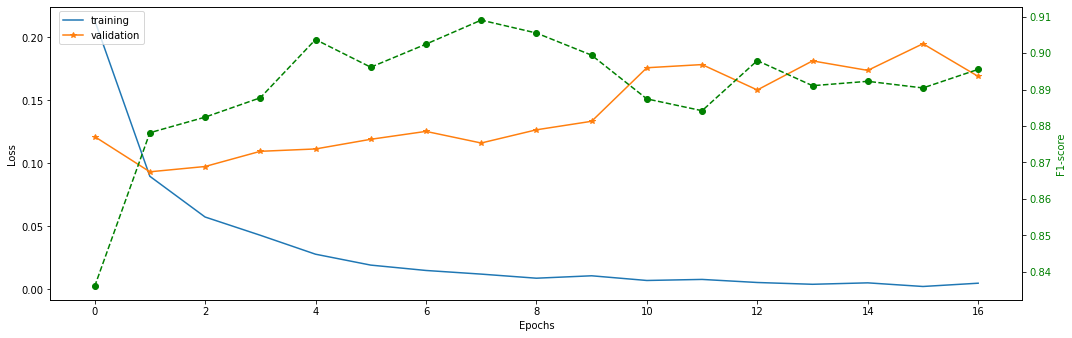

<Figure size 432x288 with 0 Axes>

In [ ]:
model.train(train_dataloader, val_dataloaders, epochs=EPOCHS, patience=PATIENCE)